## Necessary Libraries

In [63]:
#importing required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Read Dataset

In [64]:
#importing the dataset
df = pd.read_csv("Dataset/PHFood_Brazil.csv", low_memory=False)

In [65]:
# show first 5 data sample
df.head()

,Unnamed: 0,Year,Food,Food (English),Region,State,Harvest Area (hectares),Food Production (tons),Energy (kcal),Protein (g),...,Authorized,Maximum Residue Limit (MRL),Acceptable Daily Intake (ADI),Residue Percentage,Food Acquisition (kg),Food Group (FG),Population Food Group,Bean Intake (Food Group),Vegetable Intake (Food Group),Fruit Intake (Food Group)
0,1,1974,ABACATE,AVOCADO,MIDWEST,DISTRITO FEDERAL,56.0,1176.0,1.411200e+09,2.622480e+07,...,NaN,NaN,NaN,NaN,NaN,FRUIT,NaN,NaN,NaN,NaN
1,2,1974,ABACAXI,PINEAPPLE,MIDWEST,DISTRITO FEDERAL,58.0,139.0,6.672000e+07,7.506000e+05,...,NaN,NaN,NaN,NaN,NaN,FRUIT,NaN,NaN,NaN,NaN
2,3,1974,ALHO,GARLIC,MIDWEST,DISTRITO FEDERAL,2.0,3.0,4.470000e+06,1.908000e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1974,AMENDOIM,PEANUT,MIDWEST,DISTRITO FEDERAL,25.0,21.0,1.190700e+08,5.418000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1974,ARROZ,RICE,MIDWEST,DISTRITO FEDERAL,900.0,864.0,1.131370e+09,2.214333e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sanity Check

In [66]:
# Shape of the dataset
df.shape

(439299, 52)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439299 entries, 0 to 439298
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     439299 non-null  int64  
 1   Year                           439299 non-null  int64  
 2   Food                           437103 non-null  object 
 3   Food (English)                 437103 non-null  object 
 4   Region                         438273 non-null  object 
 5   State                          438273 non-null  object 
 6   Harvest Area (hectares)        432688 non-null  float64
 7   Food Production (tons)         432688 non-null  float64
 8   Energy (kcal)                  432688 non-null  float64
 9   Protein (g)                    415804 non-null  float64
 10  Lipids (g)                     432688 non-null  float64
 11  Carbohydrates (g)              432688 non-null  float64
 12  Fiber (g)                     

## Missing Values

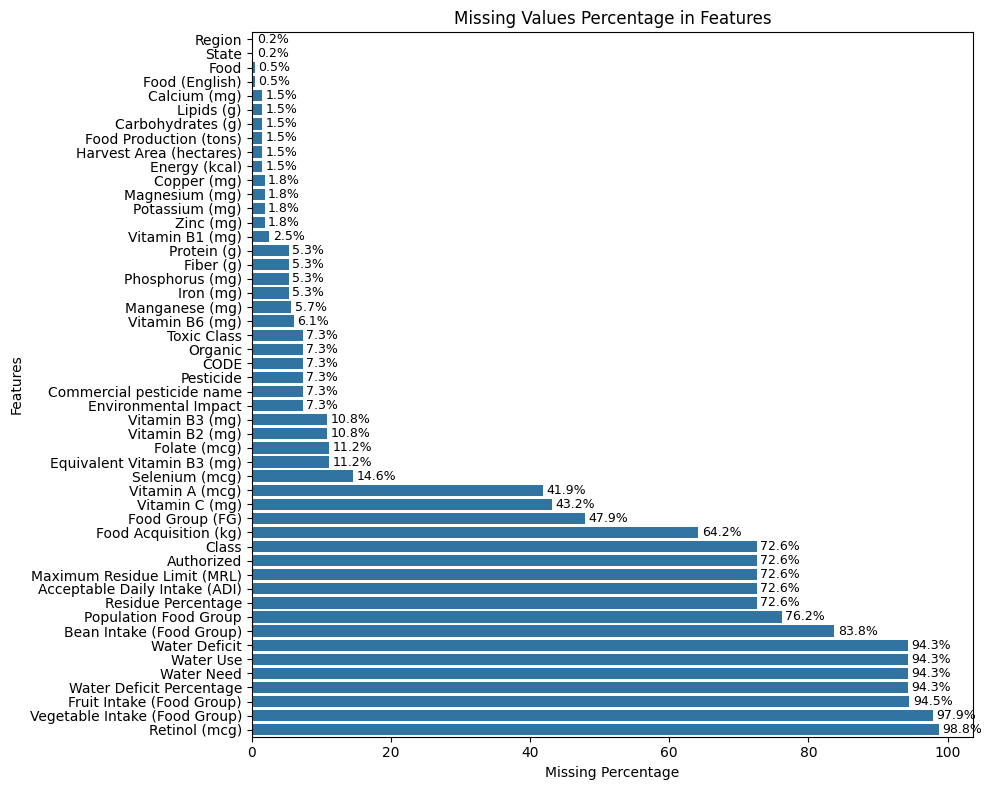

In [68]:
# Checking for missing values
missing_values = df.isnull().sum()

# Calculating the percentage of missing values
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
missing_percentage = missing_percentage.sort_values(ascending=True)  # ascending for horizontal bars

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, orient='h')
plt.xlabel("Missing Percentage")
plt.ylabel("Features")
plt.title("Missing Values Percentage in Features")

# Annotate the bars
for i, value in enumerate(missing_percentage.values):
    plt.text(value + 0.5, i, f"{value:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Histograms for Feature Distribution

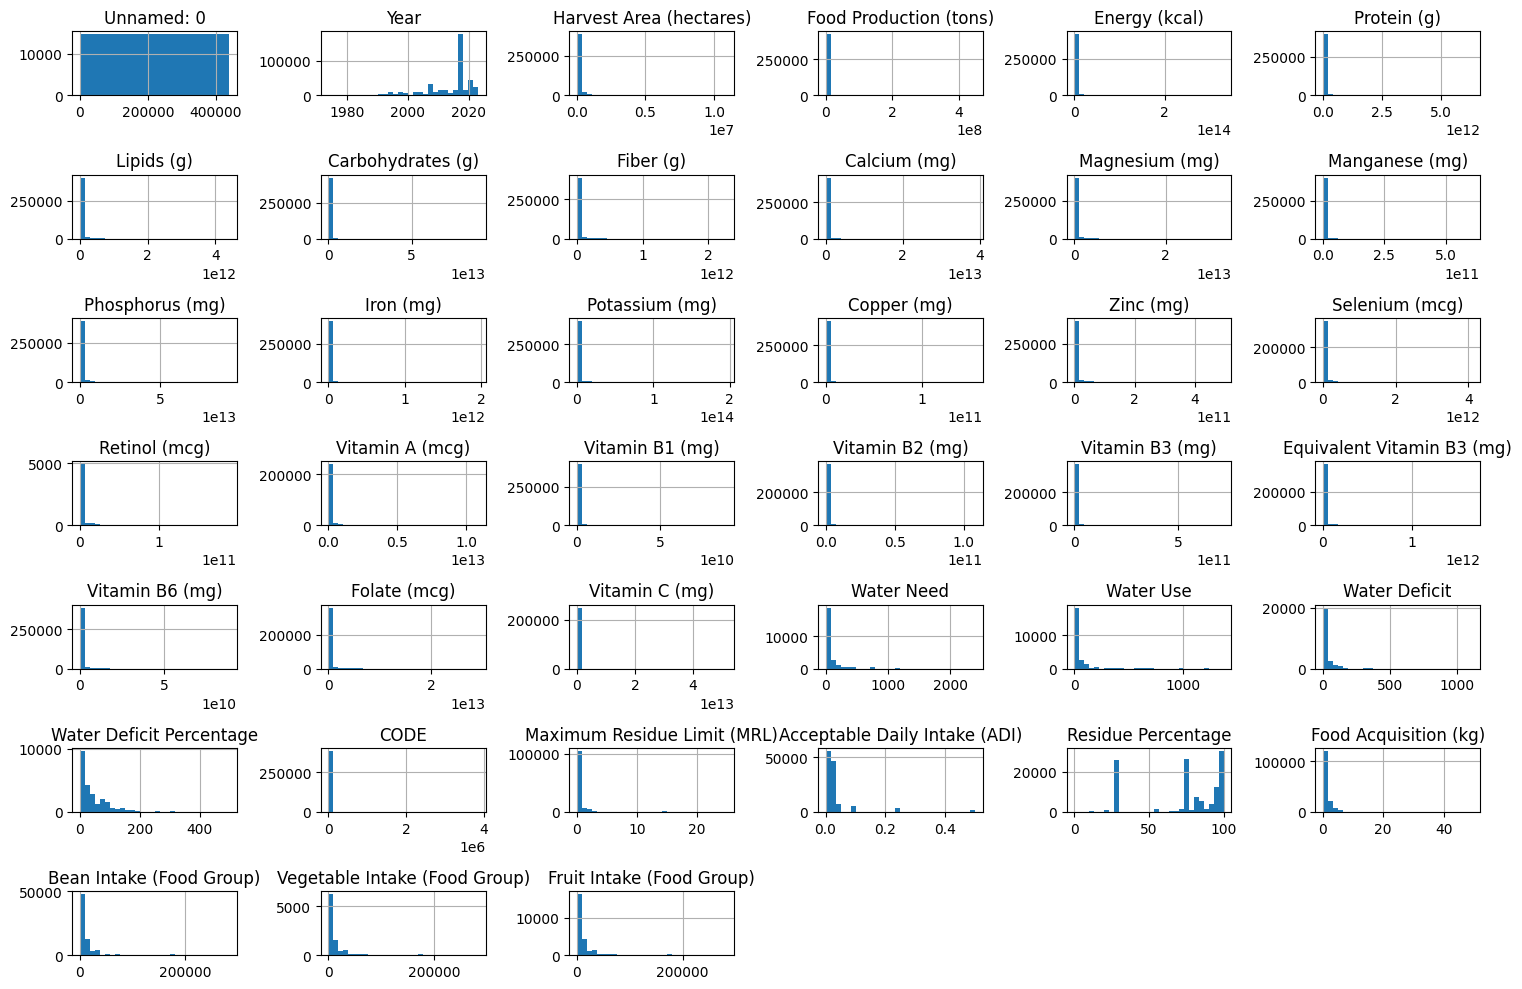

In [69]:
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

## Correlation Heatmap

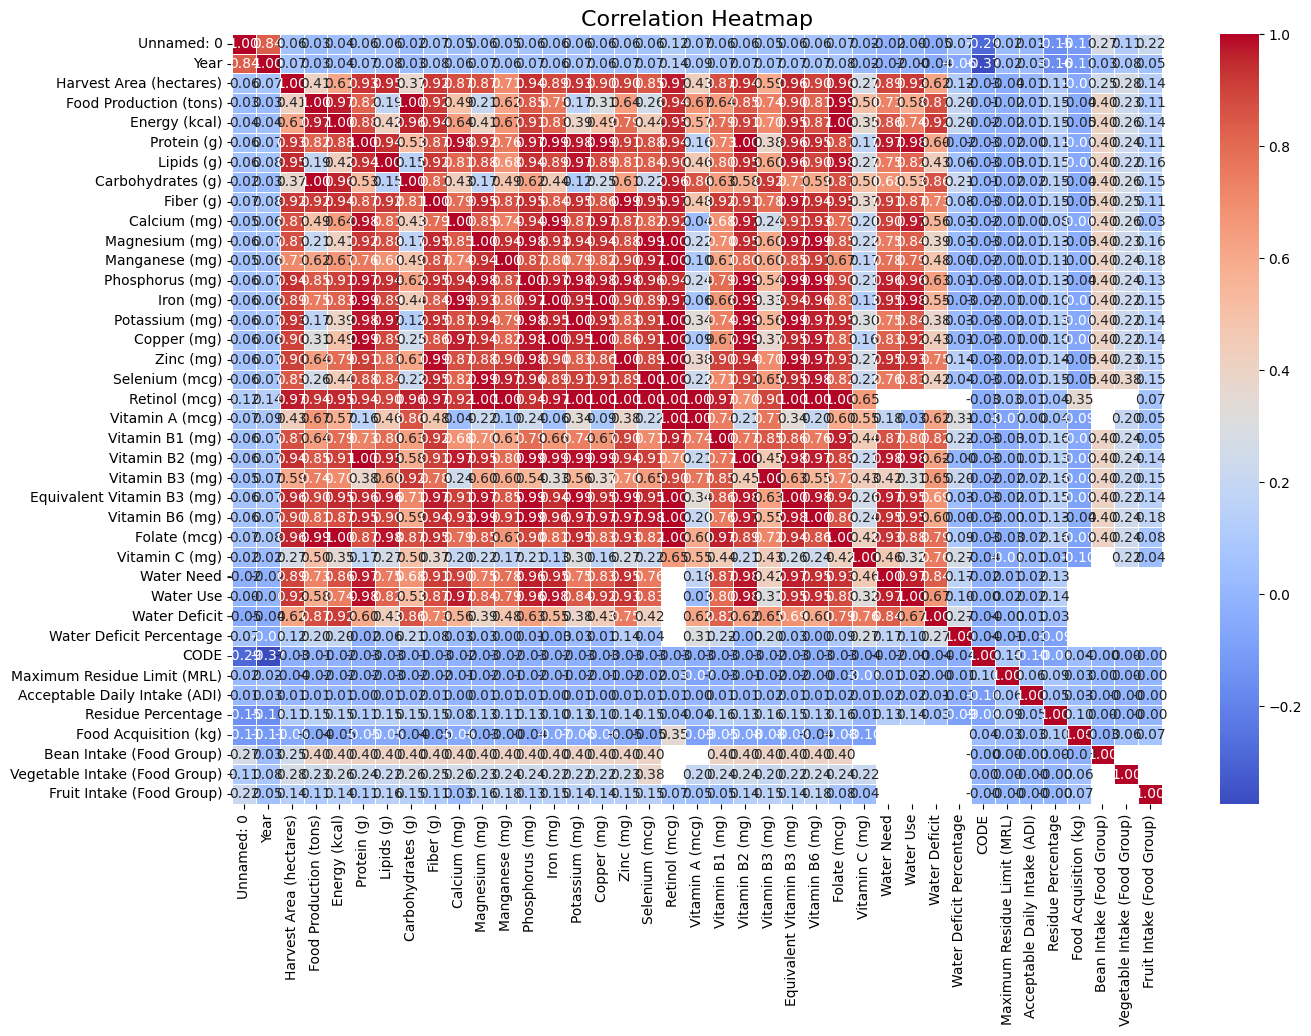

In [70]:

# Correlation heatmap for numerical features
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## Boxplots

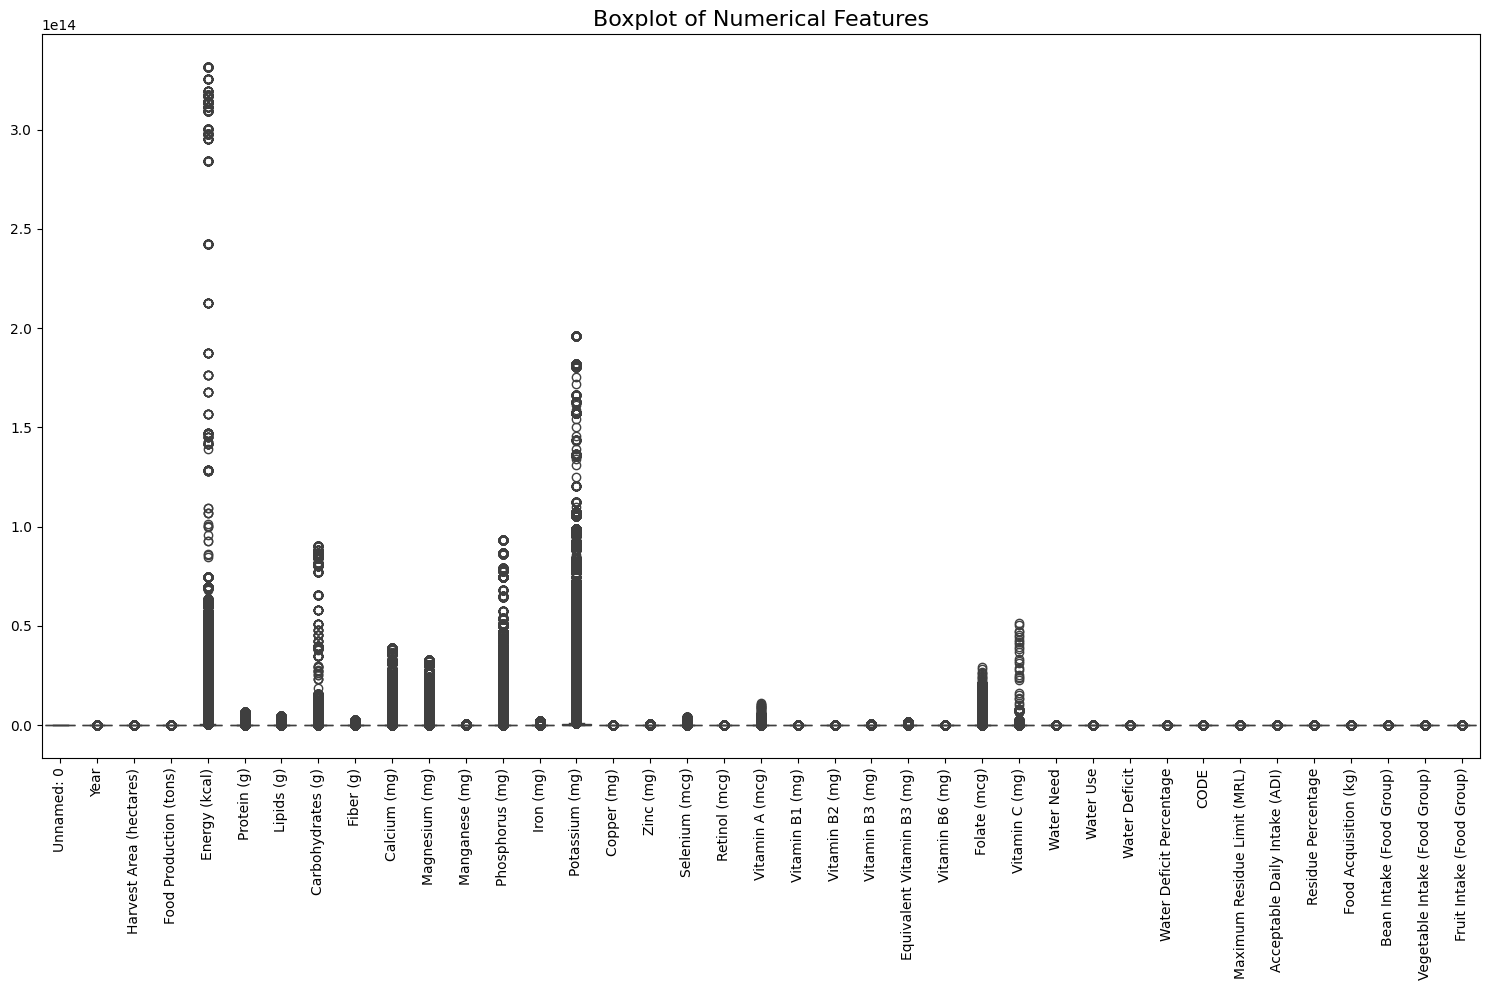

In [71]:
# Data distribution for numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Boxplot for numerical columns to check for spread and any potential outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[numerical_columns], orient="v")
plt.title('Boxplot of Numerical Features', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Target Column

In [72]:
# Creating target variable column "healthy"
df["healthy"] = df["Energy (kcal)"] < 250  # Initial rule-based labeling
df["healthy"] = df["healthy"].astype(int)

# Define a more comprehensive health score
df["health_score"] = (
    df["Protein (g)"] * 2 +            # More protein = better
    df["Fiber (g)"] * 1.5 +            # Fiber is also good
    df["Vitamin A (mcg)"] * 0.5 +
    df["Vitamin C (mg)"] * 0.5 +
    df["Iron (mg)"] * 0.5 +
    df["Calcium (mg)"] * 0.5 -
    df["Lipids (g)"] * 1 -             # Fats and carbs reduce score
    df["Carbohydrates (g)"] * 0.5
)

# Classify as healthy if above median health score
df["healthy"] = (df["health_score"] >= df["health_score"].median()).astype(int)

# Foods above the median score → healthy = 1
# Foods below the median score → healthy = 0

## feature correlation with target

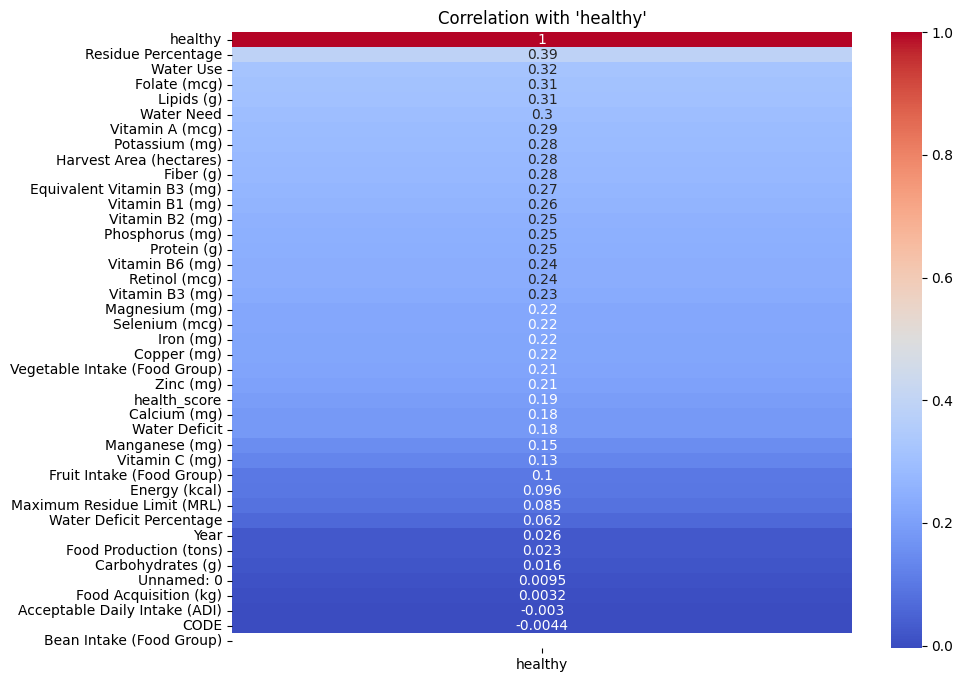

In [73]:
# Select only numeric columns to avoid string-to-float error
numeric_df = df.select_dtypes(include=['number'])

# Compute correlations on numeric columns only
corr = numeric_df.corr()

# Plot correlation with the target 'healthy'
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['healthy']].sort_values('healthy', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with 'healthy'")
plt.show()

## Class Balance

healthy
0    321606
1    117693
Name: count, dtype: int64


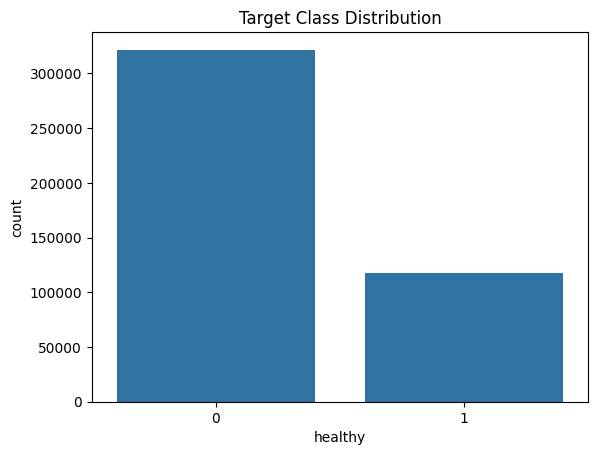

In [74]:
print(df['healthy'].value_counts())

sns.countplot(data=df, x='healthy')
plt.title('Target Class Distribution')
plt.show()
# As we see we have a slightly imbalanced dataset, we can use SMOTE to balance the dataset also class weights in models.

# Data Preprocessing

## Dropping Unnecessary Columns

In [75]:
# Dropping unnecessary columns (50% missing values)
df = df.dropna(thresh=0.5 * len(df), axis=1)

# Drop rows where target Target (Healthy) is missing
df = df.dropna(subset=['healthy'])

# Display all columns after dropping
print(df.columns)

Index(['Unnamed: 0', 'Year', 'Food', 'Food (English)', 'Region', 'State',
       'Harvest Area (hectares)', 'Food Production (tons)', 'Energy (kcal)',
       'Protein (g)', 'Lipids (g)', 'Carbohydrates (g)', 'Fiber (g)',
       'Calcium (mg)', 'Magnesium (mg)', 'Manganese (mg)', 'Phosphorus (mg)',
       'Iron (mg)', 'Potassium (mg)', 'Copper (mg)', 'Zinc (mg)',
       'Selenium (mcg)', 'Vitamin A (mcg)', 'Vitamin B1 (mg)',
       'Vitamin B2 (mg)', 'Vitamin B3 (mg)', 'Equivalent Vitamin B3 (mg)',
       'Vitamin B6 (mg)', 'Folate (mcg)', 'Vitamin C (mg)', 'CODE',
       'Commercial pesticide name', 'Pesticide', 'Organic', 'Toxic Class',
       'Environmental Impact', 'Food Group (FG)', 'healthy', 'health_score'],
      dtype='object')


In [76]:

# List of columns to drop
columns_to_drop = ["Unnamed: 0", "Year", "Region", "State", "Harvest Area (hectares)", "Food Production (tons)", "CODE", "Commercial pesticide name", "Pesticide","Organic", "Toxic Class","Environmental Impact", "Food","Food Group (FG)", "Food (English)"] 

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

# Check remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439299 entries, 0 to 439298
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Energy (kcal)               432688 non-null  float64
 1   Protein (g)                 415804 non-null  float64
 2   Lipids (g)                  432688 non-null  float64
 3   Carbohydrates (g)           432688 non-null  float64
 4   Fiber (g)                   415804 non-null  float64
 5   Calcium (mg)                432688 non-null  float64
 6   Magnesium (mg)              431178 non-null  float64
 7   Manganese (mg)              414294 non-null  float64
 8   Phosphorus (mg)             415804 non-null  float64
 9   Iron (mg)                   415804 non-null  float64
 10  Potassium (mg)              431178 non-null  float64
 11  Copper (mg)                 431178 non-null  float64
 12  Zinc (mg)                   431178 non-null  float64
 13  Selenium (mcg)

## Handling Missing Values

In [77]:

# Fill numerical columns with mean
num_cols = df.select_dtypes(include=['number']).columns
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Fill categorical columns with mode — only if such columns exist
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(df[cat_cols]), columns=cat_cols, index=df.index)

## Outliers Removal

In [78]:

# Compute Q1, Q3, and IQR for numerical columns
numeric_df = df.select_dtypes(include=['number'])
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR method
outliers_iqr = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()

# Remove outliers using IQR method
df_no_outliers_iqr = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Show dataset shape changes
rows_removed = df.shape[0] - df_no_outliers_iqr.shape[0]
print(f"\nOriginal shape: {df.shape}")
print(f"Shape after removing outliers (IQR method): {df_no_outliers_iqr.shape}")
print(f"Total rows removed: {rows_removed}")


Original shape: (439299, 24)
Shape after removing outliers (IQR method): (291761, 24)
Total rows removed: 147538


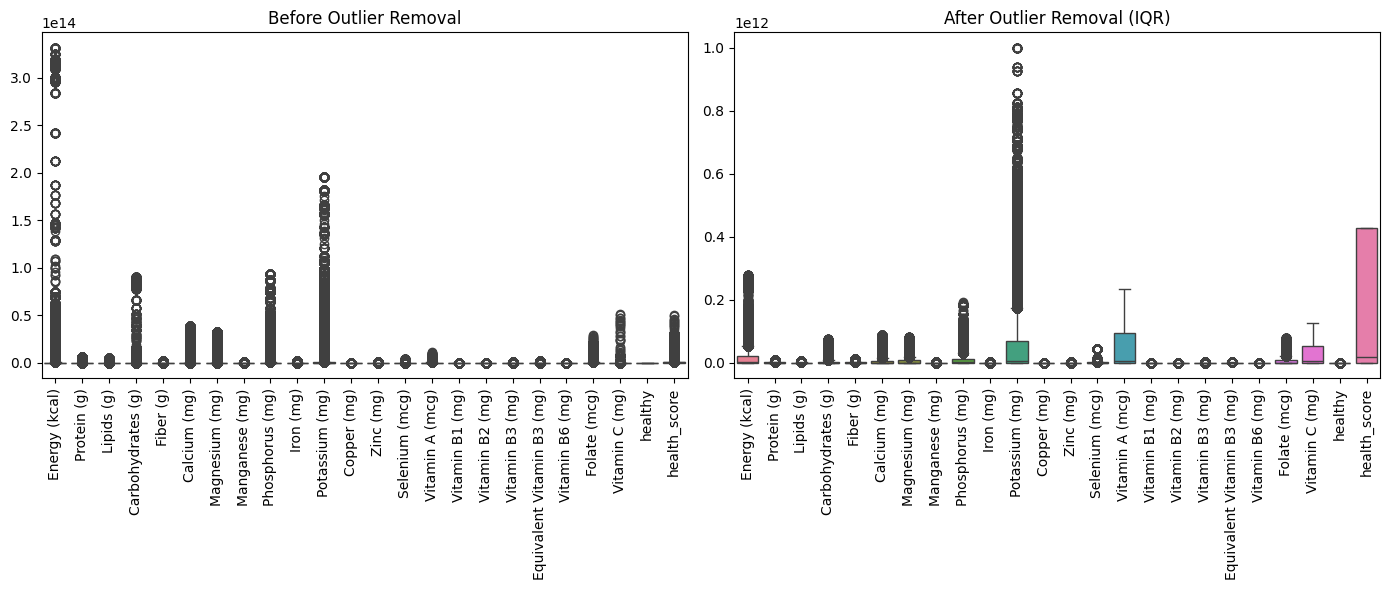

In [79]:
# Visualize the distribution of numerical features before and after outlier removal

# Select numeric columns again to avoid issues
numeric_cols = df.select_dtypes(include=['number']).columns

# Adjust figure size for better visualization
plt.figure(figsize=(14, 6))

# Before Outlier Removal
plt.subplot(1, 2, 1)
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title('Before Outlier Removal')

# After Outlier Removal
plt.subplot(1, 2, 2)
sns.boxplot(data=df_no_outliers_iqr[numeric_cols])
plt.xticks(rotation=90)
plt.title('After Outlier Removal (IQR)')

plt.tight_layout()
plt.show()

## Encoding

In [80]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns # List of categorical columns
encoders = {} # Dictionary to store encoders

# Loop through each categorical column and apply Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

## Spliting The Data

In [81]:
# Splitting the dataset into features and target variable (70% train, 30% test)

# X: features, y: target
X = df.drop(["healthy", "health_score"], axis=1)
y = df["healthy"]

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

In [82]:
# Splitting 30% test into 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

## Applying Smote

In [83]:
# Applying SMOTE to the training set

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Model Training

In [84]:
# 1. Train Random Forest
rf = RandomForestClassifier(
    class_weight='balanced', max_depth=10, random_state=42
)
rf.fit(X_train_res, y_train_res)

# 2. Train AdaBoost
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train_res, y_train_res)

# 3. Train XGBoost
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=2,
    max_depth=4,
    random_state=42
)
xgb.fit(X_train_res, y_train_res)

# 4. Evaluate on validation set
models = {
    "Random Forest": rf,
    "AdaBoost": ada,
    "XGBoost": xgb
}
for name, model in models.items():
    print(f"\n==== {name} on Test Set ====")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


==== Random Forest on Test Set ====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     48241
         1.0       0.99      1.00      1.00     17654

    accuracy                           1.00     65895
   macro avg       1.00      1.00      1.00     65895
weighted avg       1.00      1.00      1.00     65895

ROC AUC: 1.0000

==== AdaBoost on Test Set ====
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     48241
         1.0       0.97      0.99      0.98     17654

    accuracy                           0.99     65895
   macro avg       0.99      0.99      0.99     65895
weighted avg       0.99      0.99      0.99     65895

ROC AUC: 0.9995

==== XGBoost on Test Set ====
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     48241
         1.0       1.00      1.00      1.00     17654

    accuracy                           1.00     65

#  Hyperparameter tuning

### Random Forest

In [85]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_random = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
rf_random.fit(X_train_res, y_train_res)

best_rf = rf_random.best_estimator_
print("Best Random Forest Parameters:", rf_random.best_params_)

Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


### AdaBoost

In [86]:
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

ada = AdaBoostClassifier(random_state=42)
ada_random = RandomizedSearchCV(ada, ada_params, n_iter=10, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
ada_random.fit(X_train_res, y_train_res)

best_ada = ada_random.best_estimator_
print("Best AdaBoost Parameters:", ada_random.best_params_)

Best AdaBoost Parameters: {'n_estimators': 200, 'learning_rate': 1.0}


### Xgboost

In [87]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=2,
    random_state=42
)

xgb_random = RandomizedSearchCV(xgb, xgb_params, n_iter=15, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
xgb_random.fit(X_train_res, y_train_res)

best_xgb = xgb_random.best_estimator_
print("Best XGBoost Parameters:", xgb_random.best_params_)

Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


### Voting Classifier

In [88]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('ada', best_ada),
        ('xgb', best_xgb)
    ],
    voting='soft'  # soft uses probabilities
)

voting_clf.fit(X_train_res, y_train_res)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('ada',
                              AdaBoostClassifier(n_estimators=200,
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stoppin...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

Confusion Matrix:
 [[48241     0]
 [    1 17653]]

Accuracy:  1.0000
Precision: 1.0000
Recall:    0.9999
F1 Score:  1.0000
ROC AUC:   1.0000

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     48241
         1.0       1.00      1.00      1.00     17654

    accuracy                           1.00     65895
   macro avg       1.00      1.00      1.00     65895
weighted avg       1.00      1.00      1.00     65895



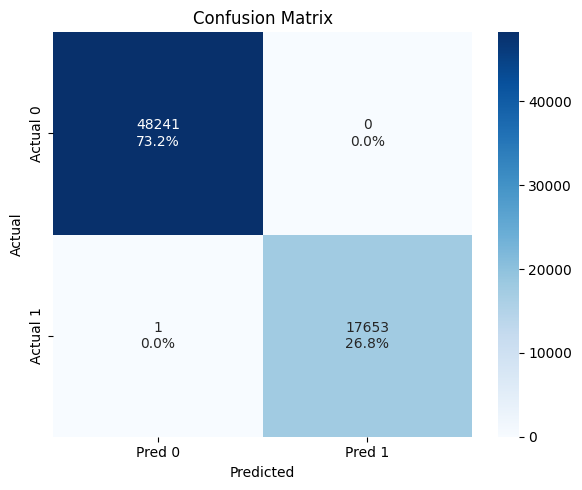

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_auc_score
)

# === Predict on test set ===
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

# === Confusion Matrix and Metrics ===
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# === Print Metrics ===
print("Confusion Matrix:\n", cm)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# === Plot Confusion Matrix with Percentages ===
plt.figure(figsize=(6, 5))
group_counts = [f"{value}" for value in cm.flatten()]
group_percentages = [f"{(value / np.sum(cm)) * 100:.1f}%" for value in cm.flatten()]
labels = [f"{count}\n{percent}" for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Result Visulization

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Random Forest,0.999985,1.000000,0.999943,0.999972,1.000000
AdaBoost,0.997542,0.992510,0.998357,0.995425,0.999982
XGBoost,0.999954,0.999887,0.999943,0.999915,1.000000
Voting Ensemble,0.999985,1.000000,0.999943,0.999972,1.000000


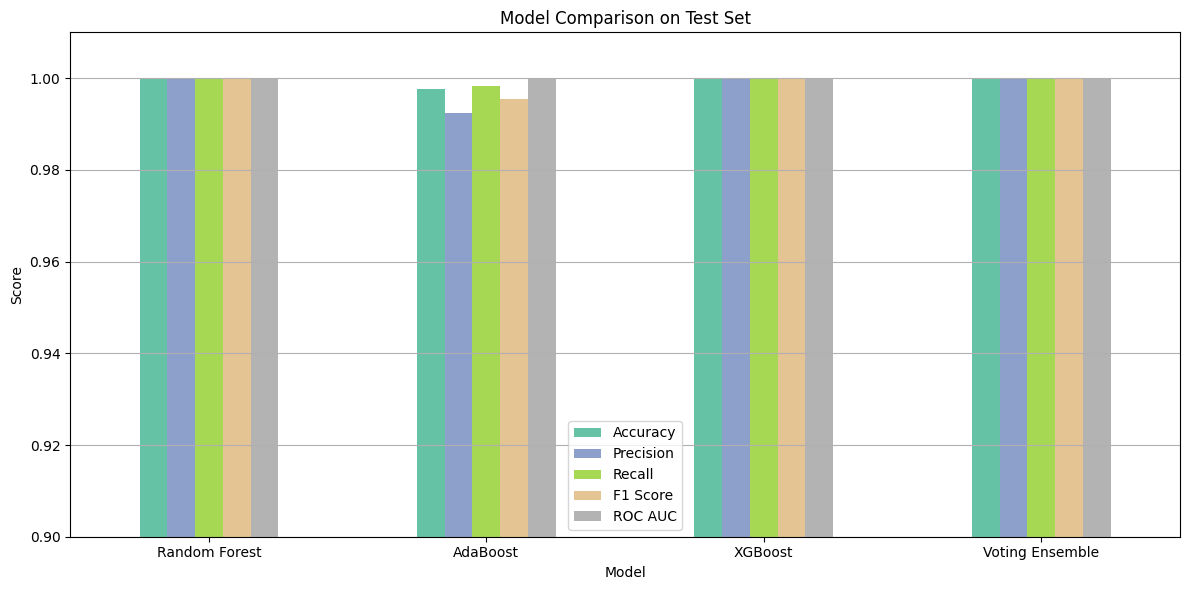

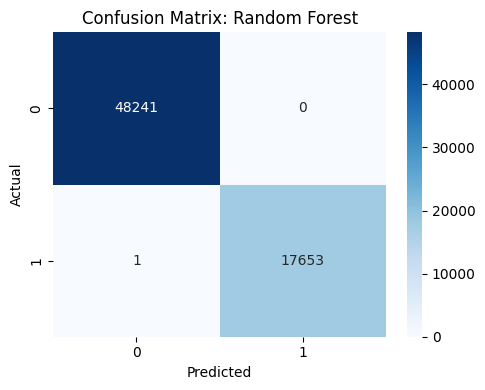

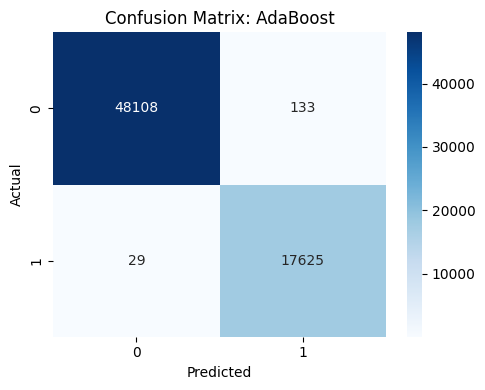

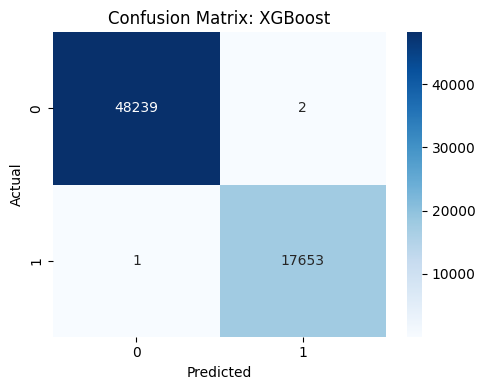

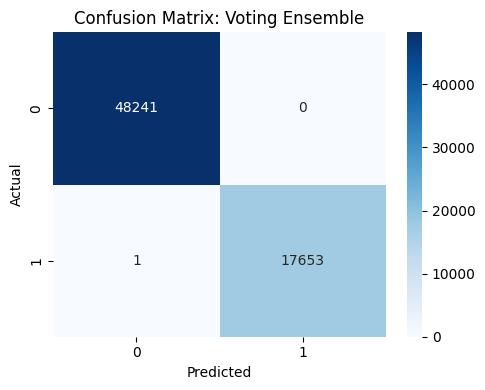

In [90]:
# Final Evaluation and Visualization

# Evaluate all models on the test set
results = []
conf_matrices = {}

models = {
    "Random Forest": best_rf,
    "AdaBoost": best_ada,
    "XGBoost": best_xgb,
    "Voting Ensemble": voting_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Create comparison table
df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
display(df_results)

# Bar plot for metric comparison
df_results.plot(kind="bar", figsize=(12, 6), ylim=(0.9, 1.01), colormap="Set2")
plt.title("Model Comparison on Test Set")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Heatmaps for confusion matrices
for name, matrix in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
